In [50]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


## 数据准备

```shell
$ tree -L 1 cifar-10                                    
cifar-10
├── sampleSubmission.csv
├── test
├── train
└── trainLabels.csv
```

In [51]:
from pathlib import Path

DATA_DIR = Path("./cifar-10")

train_labels_file = DATA_DIR / "trainLabels.csv"
test_csv_file = DATA_DIR / "sampleSubmission.csv" #测试集模板csv文件
train_folder = DATA_DIR / "train"
test_folder = DATA_DIR / "test"

#所有的类别
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

def parse_csv_file(filepath, folder): #filepath:csv文件路径，folder:图片所在文件夹
    """Parses csv files into (filename(path), label) format"""
    results = []
    #读取所有行
    with open(filepath, 'r') as f:
#       lines = f.readlines()  为什么加[1:]，可以试这个
        #第一行不需要，因为第一行是标题
        lines = f.readlines()[1:] 
    for line in lines:#依次去取每一行
        image_id, label_str = line.strip('\n').split(',') #图片id 和标签分离
        image_full_path = folder / f"{image_id}.png"
        results.append((image_full_path, label_str)) #得到对应图片的路径和分类
    return results

#解析对应的文件夹
train_labels_info = parse_csv_file(train_labels_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)
#打印
import pprint
pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_csv_info[0:5])
print(len(train_labels_info), len(test_csv_info))

[(WindowsPath('cifar-10/train/1.png'), 'frog'),
 (WindowsPath('cifar-10/train/2.png'), 'truck'),
 (WindowsPath('cifar-10/train/3.png'), 'truck'),
 (WindowsPath('cifar-10/train/4.png'), 'deer'),
 (WindowsPath('cifar-10/train/5.png'), 'automobile')]
[(WindowsPath('cifar-10/test/1.png'), 'cat'),
 (WindowsPath('cifar-10/test/2.png'), 'cat'),
 (WindowsPath('cifar-10/test/3.png'), 'cat'),
 (WindowsPath('cifar-10/test/4.png'), 'cat'),
 (WindowsPath('cifar-10/test/5.png'), 'cat')]
50000 300000


In [52]:
# train_df = pd.DataFrame(train_labels_info)
train_df = pd.DataFrame(train_labels_info[0:45000]) # 取前45000张图片作为训练集
valid_df = pd.DataFrame(train_labels_info[45000:]) # 取后5000张图片作为验证集
test_df = pd.DataFrame(test_csv_info)

train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

               filepath       class
0  cifar-10\train\1.png        frog
1  cifar-10\train\2.png       truck
2  cifar-10\train\3.png       truck
3  cifar-10\train\4.png        deer
4  cifar-10\train\5.png  automobile
                   filepath       class
0  cifar-10\train\45001.png       horse
1  cifar-10\train\45002.png  automobile
2  cifar-10\train\45003.png        deer
3  cifar-10\train\45004.png  automobile
4  cifar-10\train\45005.png    airplane
              filepath class
0  cifar-10\test\1.png   cat
1  cifar-10\test\2.png   cat
2  cifar-10\test\3.png   cat
3  cifar-10\test\4.png   cat
4  cifar-10\test\5.png   cat


In [53]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class Cifar10Dataset(Dataset):
    df_map = {
        "train": train_df,
        "eval": valid_df,
        "test": test_df
    }
    label_to_idx = {label: idx for idx, label in enumerate(class_names)} # 类别映射为idx
    idx_to_label = {idx: label for idx, label in enumerate(class_names)} # idx映射为类别,为了test测试集使用
    def __init__(self, mode, transform=None):
        self.df = self.df_map.get(mode, None) # 获取对应模式的df，不同字符串对应不同模式
        if self.df is None:
            raise ValueError("mode should be one of train, val, test, but got {}".format(mode))
        # assert self.df, "df is None"
        self.transform = transform
        
    def __getitem__(self, index):
        img_path, label = self.df.iloc[index] # 获取图片路径和标签
        img = Image.open(img_path).convert('RGB')
        # # img 转换为 channel first
        # img = img.transpose((2, 0, 1))
        # transform
        img = self.transform(img) # 数据增强
        # label 转换为 idx
        label = self.label_to_idx[label]
        return img, label
    
    def __len__(self):
        return self.df.shape[0] # 返回df的行数,样本数
    
IMAGE_SIZE = 32
# mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
# mean, std = [0.4367, 0.4267, 0.3946], [0.2465, 0.2419, 0.2359]

transforms_train = transforms.Compose([
        # resize
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), #缩放
        # random rotation 40
        transforms.RandomRotation(40), #随机旋转
        # horizaontal flip
        transforms.RandomHorizontalFlip(),  #随机水平翻转
        transforms.ToTensor(), #转换为tensor
        # transforms.Normalize(mean, std) #标准化
    ]) #数据增强

transforms_eval = transforms.Compose([
        # resize
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        # transforms.Normalize(mean, std)
    ])
# ToTensor还将图像的维度从[height, width, channels]转换为[channels, height, width]。
train_ds = Cifar10Dataset("train", transforms_train)
eval_ds = Cifar10Dataset("eval", transforms_eval)

In [54]:
train_ds[0][0].shape # 图片的shape,输入

torch.Size([3, 32, 32])

In [55]:
print(train_ds.idx_to_label)  # 类别映射为idx
train_ds.label_to_idx # idx映射为类别

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [70]:
batch_size = 256
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)   
eval_dl = DataLoader(eval_ds, batch_size=batch_size, shuffle=False)

In [57]:
# 遍历train_ds得到每张图片，计算每个通道的均值和方差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2))
        std += img.std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std

# 经过 normalize 后 均值为0，方差为1
print(cal_mean_std(train_ds))

(tensor([0.4370, 0.4269, 0.3948]), tensor([0.2465, 0.2419, 0.2360]))


## 定义模型

In [58]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),# 批标准化，在通道数做的归一化
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same"), #输出尺寸（128，32，32）
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2), #输出尺寸（128，16，16）
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding="same"), #输出尺寸（256，16，16）
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2),#输出尺寸（256，8，8）
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding="same"), #输出尺寸（512，8，8）
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2), #输出尺寸（512，4，4）
            nn.Flatten(), #展平
            nn.Linear(8192, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        ) #Sequential自动连接各层，把各层的输出作为下一层的输入
        
    def forward(self, x):
        return self.model(x)
        
for key, value in CNN(len(class_names)).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")
    


             model.0.weight             paramerters num: 3456
              model.0.bias              paramerters num: 128
             model.2.weight             paramerters num: 128
              model.2.bias              paramerters num: 128
             model.3.weight             paramerters num: 147456
              model.3.bias              paramerters num: 128
             model.5.weight             paramerters num: 128
              model.5.bias              paramerters num: 128
             model.7.weight             paramerters num: 294912
              model.7.bias              paramerters num: 256
             model.9.weight             paramerters num: 256
              model.9.bias              paramerters num: 256
            model.10.weight             paramerters num: 589824
             model.10.bias              paramerters num: 256
            model.12.weight             paramerters num: 256
             model.12.bias              paramerters num: 256
            mo

In [59]:
total_params = sum(p.numel() for p in CNN(len(class_names)).parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 8779914


In [60]:
512*4*4

8192

In [61]:
input_4d = torch.randn(32, 3, 64, 64)  # 32 个样本，3 个通道，图像大小为 64x64
bn2d = nn.BatchNorm2d(3)              # 对 3 个通道进行归一化
output_4d = bn2d(input_4d)
output_4d.shape

torch.Size([32, 3, 64, 64])

In [62]:
output_4d

tensor([[[[ 1.4147e+00, -1.5962e+00,  4.7182e-02,  ..., -9.7320e-02,
           -4.1803e-01, -1.3684e-01],
          [ 1.2733e+00,  1.6708e+00,  5.0586e-02,  ..., -2.2938e+00,
            7.4902e-01,  1.0007e+00],
          [ 1.2675e+00,  1.1067e+00,  7.1777e-01,  ...,  2.7557e-01,
           -2.0401e+00,  1.0661e+00],
          ...,
          [ 1.9632e+00, -1.1313e-01,  1.0421e+00,  ...,  1.0883e+00,
            4.6591e-01,  8.1062e-01],
          [ 1.1245e+00, -1.0331e+00, -2.7841e-02,  ..., -1.5423e+00,
           -4.3086e-01, -2.1530e-01],
          [ 5.5437e-02,  1.8286e+00, -7.8759e-01,  ...,  1.2673e-01,
            1.1417e+00,  1.6712e+00]],

         [[ 1.0917e+00, -1.2986e+00,  2.0586e-01,  ...,  1.6081e+00,
           -2.4140e-01, -1.5377e+00],
          [-6.8024e-01, -7.7253e-01,  2.4797e-01,  ..., -1.7091e-01,
           -4.1075e-01, -3.2572e-01],
          [ 3.3994e-01, -4.0507e-02, -1.3883e+00,  ...,  3.9374e-03,
            5.7939e-01, -1.6503e-01],
          ...,
     

In [63]:
bn2d = nn.BatchNorm2d(1)              # 对 3 个通道进行归一化
output_4d1 = bn2d(input_4d[:, 0:1, :, :])
output_4d1

tensor([[[[ 1.4147e+00, -1.5962e+00,  4.7182e-02,  ..., -9.7320e-02,
           -4.1803e-01, -1.3684e-01],
          [ 1.2733e+00,  1.6708e+00,  5.0586e-02,  ..., -2.2938e+00,
            7.4902e-01,  1.0007e+00],
          [ 1.2675e+00,  1.1067e+00,  7.1777e-01,  ...,  2.7557e-01,
           -2.0401e+00,  1.0661e+00],
          ...,
          [ 1.9632e+00, -1.1313e-01,  1.0421e+00,  ...,  1.0883e+00,
            4.6591e-01,  8.1062e-01],
          [ 1.1245e+00, -1.0331e+00, -2.7841e-02,  ..., -1.5423e+00,
           -4.3086e-01, -2.1530e-01],
          [ 5.5437e-02,  1.8286e+00, -7.8759e-01,  ...,  1.2673e-01,
            1.1417e+00,  1.6712e+00]]],


        [[[-5.4449e-01,  3.0065e-01, -1.0295e+00,  ..., -2.2388e-01,
            1.2278e+00,  1.4118e+00],
          [ 4.2180e-01,  1.2583e-01, -1.4893e+00,  ..., -1.2218e+00,
           -1.1025e+00, -1.3753e+00],
          [-7.9236e-01, -6.3337e-01,  1.1685e+00,  ..., -1.3990e+00,
           -6.0334e-01, -1.5456e+00],
          ...,
   

## 训练

pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

In [64]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item())
        
        preds = logits.argmax(axis=-1)    # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
        
    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc


### TensorBoard 可视化


训练过程中可以使用如下命令启动tensorboard服务。

```shell
tensorboard \
    --logdir=runs \     # log 存放路径
    --host 0.0.0.0 \    # ip
    --port 8848         # 端口
```

In [65]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))
        
    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss", 
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )
        
    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )
        
    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,
            
        )
    
    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


### Save Best


In [66]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



### Early Stop

In [67]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):
        return self.counter >= self.patience


In [68]:
# 训练
def training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1) #最大值的索引
            
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())     # 计算准确率
                loss = loss.cpu().item() # 计算损失
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step # 记录每一步的损失和准确率
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()
                    
                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step, 
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                            )
                
                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict
        

epoch = 20

model = CNN(num_classes=10)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
tensorboard_callback = TensorBoardCallback("runs/cifar-10")
tensorboard_callback.draw_model(model, [1, 3, IMAGE_SIZE, IMAGE_SIZE])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/cifar-10", save_step=len(train_dl), save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

model = model.to(device)


In [71]:
record = training(
    model,
    train_dl,
    eval_dl,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=tensorboard_callback,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_dl)
    )

  0%|          | 0/3520 [00:00<?, ?it/s]

Early stop at epoch 18 / global_step 3168


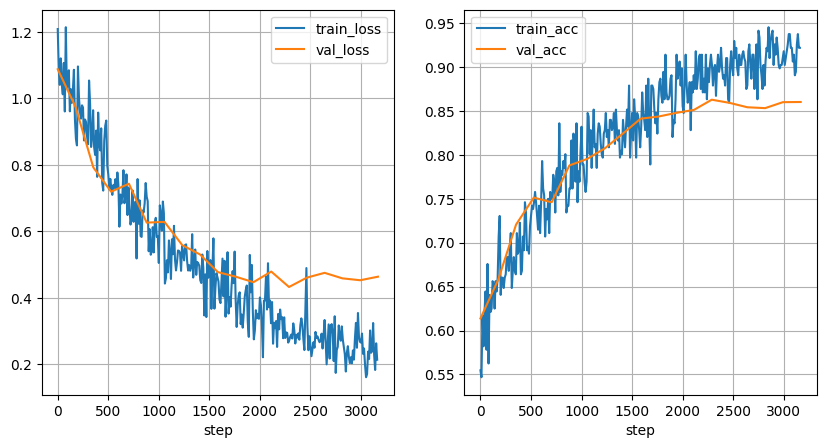

In [72]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):    
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curves(record, sample_step=10)  #横坐标是 steps

# 评估

In [73]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/cifar-10/best.ckpt", map_location="cpu"))

model.eval()
loss, acc = evaluating(model, eval_dl, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

C:\Users\false\AppData\Local\Temp\ipykernel_25780\1513600467.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoints/cifar-10/best.

loss:     0.4638
accuracy: 0.8602


# 推理

In [74]:
# test_df
test_ds = Cifar10Dataset("test", transform=transforms_eval)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)

preds_collect = [] # 预测结果收集器
model.eval()
for data, fake_label in tqdm(test_dl):
    data = data.to(device=device)
    logits = model(data) #得到预测结果
    preds = [test_ds.idx_to_label[idx] for idx in logits.argmax(axis=-1).cpu().tolist()] # 得到预测类别，idx_to_label是id到字符串类别的映射
    preds_collect.extend(preds)
    
test_df["label"] = preds_collect # 增加预测类别列,比赛要求这一列是label
test_df.head()

  0%|          | 0/1172 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [1]:
64*4688

300032

In [26]:
# 导出 submission.csv
test_df.to_csv("submission.csv", index=False)